<a href="https://colab.research.google.com/github/apoorva-coder/ideal-AI-adventure/blob/explore-dl/chapter_linear-regression/Linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install --upgrade d2l==1.0.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip3 install matplotlib-inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Synthetic Regression Data



In [9]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import tensorflow as tf


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()
      

In [ ]:
class SyntheticRegressionData(d2l.DataModule):  
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = tf.random.normal((n, w.shape[0]))
        noise = tf.random.normal((n, 1)) * noise
        self.y = tf.matmul(self.X, tf.reshape(w, (-1,1))) + b + noise

In [ ]:
@d2l.add_to_class(d2l.DataModule)  
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    shuffle_buffer = tensors[0].shape[0] if train else 1
    return tf.data.Dataset.from_tensor_slices(tensors).shuffle(
        buffer_size=shuffle_buffer).batch(self.batch_size)

@d2l.add_to_class(SyntheticRegressionData)  
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

# Linear Regression

In [ ]:
class LinearRegressionScratch(d2l.Module):
  def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        w = tf.random.normal((num_inputs, 1), mean=0, stddev=0.01)
        b = tf.zeros(1)
        self.w = tf.Variable(w, trainable=True)
        self.b = tf.Variable(b, trainable=True)

In [ ]:
@d2l.add_to_class(LinearRegressionScratch) 
def forward(self, X):
    """The linear regression model."""
    return tf.matmul(X, self.w) + self.b

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)  
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return tf.reduce_mean(l)

In [ ]:
class SGD(d2l.HyperParameters):  
    def __init__(self, lr):
        """Minibatch stochastic gradient descent."""
        self.save_hyperparameters()

    def apply_gradients(self, grads_and_vars):
        for grad, param in grads_and_vars:
            param.assign_sub(self.lr * grad)

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)  
def configure_optimizers(self):
    return SGD(self.lr)

In [ ]:
@d2l.add_to_class(d2l.Trainer)  
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  
def fit_epoch(self):
    self.model.training = True
    for batch in self.train_dataloader:
        with tf.GradientTape() as tape:
            loss = self.model.training_step(self.prepare_batch(batch))
        grads = tape.gradient(loss, self.model.trainable_variables)
        if self.gradient_clip_val > 0:
            grads = self.clip_gradients(self.gradient_clip_val, grads)
        self.optim.apply_gradients(zip(grads, self.model.trainable_variables))
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.training = False
    for batch in self.val_dataloader:
        self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1


Reasons why experts say tensorflow is messy!! And ask to shift to pytorch. But tensorflow is a matured platform and for a edge AI developer it has provided more flexibility to port to tflite which can be used efficiently in tiny devices.

In [ ]:
model = LinearRegressionScratch(2, lr=0.03)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)


AttributeError: ignored

# Linear regression concise

## Model definition

In [ ]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l


The dense class in keras contain the definition for fully connected layer. 1 is the number of output we have for the dense layer. 

Linear regrssion is a single fully connected layer with multiple inputs and single output (in deep learning!)

In [ ]:
class LinearRegression(d2l.Module):  
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        initializer = tf.initializers.RandomNormal(stddev=0.01)
        self.net = tf.keras.layers.Dense(1, kernel_initializer=initializer)


The keras framework's 'call' function is is invoked with self.net(X) which automatically maps the number of inputs

In [ ]:
@d2l.add_to_class(LinearRegression)  
def forward(self, X):
    """The linear regression model."""
    return self.net(X)


## Loss function


In [ ]:
@d2l.add_to_class(LinearRegression)  
def loss(self, y_hat, y):
    fn = tf.keras.losses.MeanSquaredError()
    return fn(y, y_hat)

## Optimization algorithm

In [ ]:
@d2l.add_to_class(LinearRegression)  
def configure_optimizers(self):
    return tf.keras.optimizers.SGD(self.lr)

## Training

In [ ]:
@d2l.add_to_class(d2l.Trainer)  
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  
def fit_epoch(self):
    self.model.training = True
    for batch in self.train_dataloader:
        with tf.GradientTape() as tape:
            loss = self.model.training_step(self.prepare_batch(batch))
        grads = tape.gradient(loss, self.model.trainable_variables)
        if self.gradient_clip_val > 0:
            grads = self.clip_gradients(self.gradient_clip_val, grads)
        self.optim.apply_gradients(zip(grads, self.model.trainable_variables))
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.training = False
    for batch in self.val_dataloader:
        self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

## Stuck again trying with pytorch

In [ ]:
model = LinearRegression(lr=0.03)
# randon data
num_train=1000
num_val=100
w=tf.constant([2, -3.4])
b=4.2
noise =0.01
n = num_train + num_val
X = tf.random.normal((n, w.shape[0]))
noise = tf.random.normal((n, 1)) * noise
y = tf.matmul(X, tf.reshape(w, (-1,1))) + b + noise
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

AttributeError: ignored

# Linear regression concise with pytorch

In [ ]:
class SyntheticRegressionData(d2l.DataModule):  
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

In [ ]:
@d2l.add_to_class(d2l.DataModule)  
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)
@d2l.add_to_class(SyntheticRegressionData) 
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

## Model definition

The fully connected layers is defined in Linear and Lazy Linear class 

Linear - allows to specify number of inputs
Lazy linear - only allows to specify the outputs



In [ ]:
class LinearRegression(d2l.Module):  
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [ ]:
@d2l.add_to_class(LinearRegression)  
def forward(self, X):
    """The linear regression model."""
    return self.net(X)

## Loss function


MSELoss computes mean squared error with 1/2 factor

In [ ]:
@d2l.add_to_class(LinearRegression)  
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

## Optimization algorithm

In [ ]:
@d2l.add_to_class(LinearRegression) 
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)


## Training

In [ ]:
@d2l.add_to_class(d2l.Trainer)  
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1


Pytorch is cleaner and smooth!

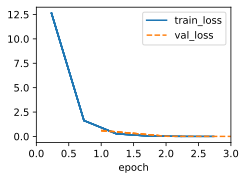

In [ ]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)


# Weight decay


In [17]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [18]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [19]:
def l2_penalty(w):
    return (w ** 2).sum() / 2


In [20]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [21]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

## training without regularizarion

L2 norm of w: 0.012453142553567886


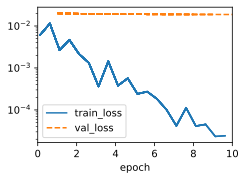

In [22]:
train_scratch(0)

## using weight decay

L2 norm of w: 0.0011818602215498686


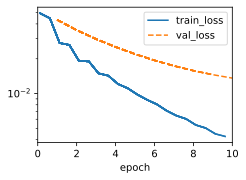

In [23]:
train_scratch(3)

In [24]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)


L2 norm of w: 0.014012581668794155


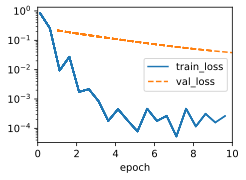

In [25]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

## Exercise d2l

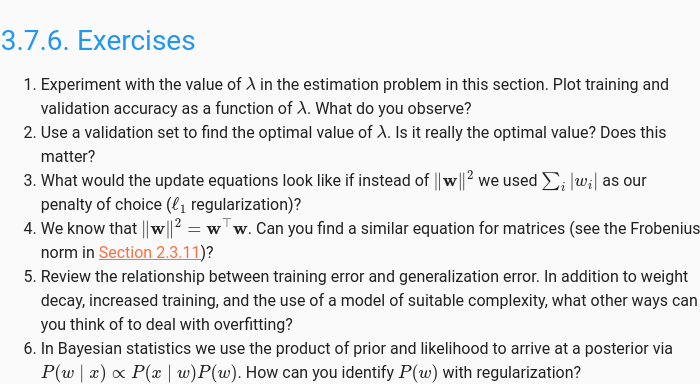

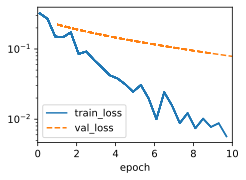

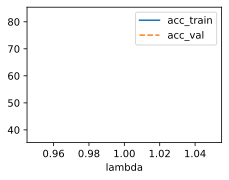

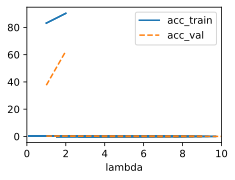

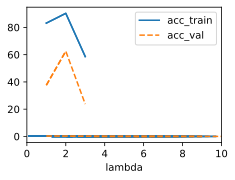

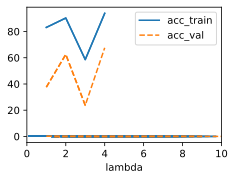

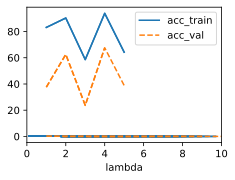

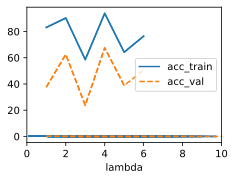

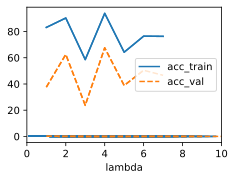

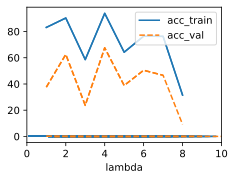

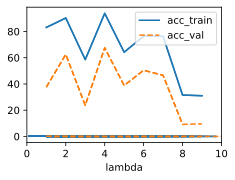

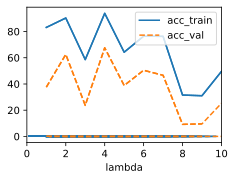

In [30]:
#1
import numpy as np

data = Data(num_train=100, num_val=100, num_inputs=200, batch_size=20)
trainer = d2l.Trainer(max_epochs=10)
test_lambds=np.arange(1,11,1)
board = d2l.ProgressBoard('lambda')

def accuracy(y_hat, y):
    return (1 - ((y_hat - y).mean() / y.mean()).abs()) * 100

def train_ex1(lambd):    
    model = WeightDecay(wd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    y_hat = model.forward(data.X)
    acc_train = accuracy(y_hat[:data.num_train], data.y[:data.num_train])
    acc_val = accuracy(y_hat[data.num_train:], data.y[data.num_train:])
    return acc_train, acc_val

for item in test_lambds:
    acc_train, acc_val = train_ex1(item)
    board.draw(item, acc_train.to(d2l.cpu()).detach().numpy(), 'acc_train', every_n=1)
    board.draw(item, acc_val.to(d2l.cpu()).detach().numpy(), 'acc_val', every_n=1)

In [ ]:
# 2 

'''No it does not matter. Lambda is a value which is used generalize and 
selecting the validation 
set which and then optimizing the lambda should not be the procedure. 
We should rather select and go through many validation sets.'''

In [ ]:
# 3

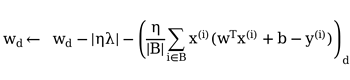

In [ ]:
# 4

